In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../Week04/datasets/perovai_devices_day6_stability_ready.csv")
model = joblib.load("datasets/perovai_best_model_week05.pkl")

features = [
    "Voc_V_Reverse",
    "Jsc_mAcm2_Reverse",
    "FF_Reverse",
    "Rs_ohm_cm2_Reverse",
    "Rsh_ohm_cm2_Reverse",
    "Delta_PCE",
    "Hysteresis_Index"
]

X = df[features]
y = df["Unstable"]

In [3]:
model.fit(X, y)

r = permutation_importance(model, X, y, n_repeats=30, random_state=42)

importances = pd.Series(r.importances_mean, index=features).sort_values()

importances

Voc_V_Reverse          0.000000
FF_Reverse             0.000000
Rs_ohm_cm2_Reverse     0.000000
Rsh_ohm_cm2_Reverse    0.000000
Delta_PCE              0.000000
Jsc_mAcm2_Reverse      0.123585
Hysteresis_Index       0.383333
dtype: float64

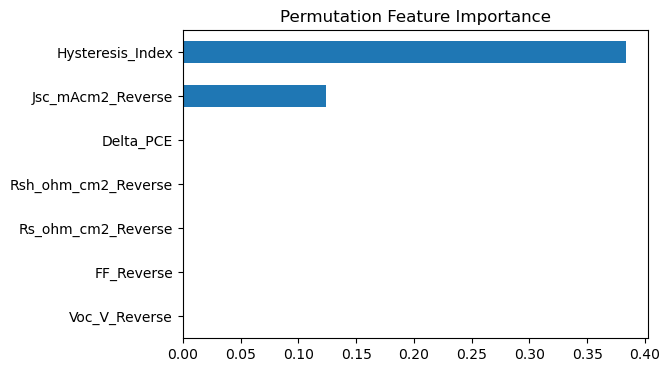

In [4]:
plt.figure(figsize=(6,4))
importances.plot(kind="barh")
plt.title("Permutation Feature Importance")
plt.show()

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_importances = []

for train_idx, test_idx in cv.split(X, y):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    r = permutation_importance(model, X.iloc[test_idx], y.iloc[test_idx], n_repeats=10, random_state=42)
    fold_importances.append(r.importances_mean)

fold_importances = pd.DataFrame(fold_importances, columns=features)

fold_importances

,Voc_V_Reverse,Jsc_mAcm2_Reverse,FF_Reverse,Rs_ohm_cm2_Reverse,Rsh_ohm_cm2_Reverse,Delta_PCE,Hysteresis_Index
0,0.0,0.000000,0.0,0.204545,0.0,0.0,0.304545
1,0.0,0.147619,0.0,0.000000,0.0,0.0,0.371429
2,0.0,0.071429,0.0,0.000000,0.0,0.0,0.466667
3,0.0,0.133333,0.0,0.000000,0.0,0.0,0.400000
4,0.0,0.052381,0.0,0.000000,0.0,0.0,0.409524


In [6]:
fold_importances.std().sort_values()

Voc_V_Reverse          0.000000
FF_Reverse             0.000000
Delta_PCE              0.000000
Rsh_ohm_cm2_Reverse    0.000000
Hysteresis_Index       0.059172
Jsc_mAcm2_Reverse      0.060516
Rs_ohm_cm2_Reverse     0.091476
dtype: float64

In [7]:
# z-score across main instability drivers
z = np.abs((df[["Delta_PCE","Hysteresis_Index","Rs_ohm_cm2_Reverse"]] - 
            df[["Delta_PCE","Hysteresis_Index","Rs_ohm_cm2_Reverse"]].mean()) /
            df[["Delta_PCE","Hysteresis_Index","Rs_ohm_cm2_Reverse"]].std())

df["Outlier"] = (z.max(axis=1) > 3).astype(int)

df[df["Outlier"] == 1][["Device","Delta_PCE","Hysteresis_Index","Rs_ohm_cm2_Reverse"]]

,Device,Delta_PCE,Hysteresis_Index,Rs_ohm_cm2_Reverse
41,device042,2.424966,0.211110,1.045415e+01
47,device048,0.000005,0.907055,1.458819e+09
81,device082,0.000002,0.733888,8.041407e+08
86,device087,0.008557,1810.071312,8.914104e+07


In [8]:
importances.to_csv("datasets/perovai_week05_day3_feature_importance.csv")
fold_importances.to_csv("datasets/perovai_week05_day3_fold_importances.csv")
df.to_csv("datasets/perovai_week05_day3_with_outliers.csv", index=False)

print("Saved explainability and outlier results.")

Saved explainability and outlier results.
